In [ ]:
Pkg.add("LibExpat"); using LibExpat
Pkg.add("Winston"); using Winston

# Pkg.clone("MXNet");
# ENV["MXNET_HOME"] = "/mxnet"

In [2]:
# using MXNet
using GraphPlot
using PyPlot
using PyCall
using StatsBase

In [3]:
using LightGraphs
import LightGraphs.SimpleGraphs: SimpleEdge, SimpleDiGraph
include("CreateOSMGraphs.jl")
using CreateOSMGraphs;
include("utils.jl")


Use "const Styles = @compat Union{Style,Dict{Int,Style}}" instead.


generate_weights_with_factors (generic function with 1 method)

### Load the map data

In [4]:
# osm_fn = "northern_stockholm.osm"
osm_fn = "kista.osm"
@time graph, vprops, eprops, edgeDict, 
nodesLLA, highways, geohash2edgedict = CreateOSMGraphs.CreateOSMGraph(osm_fn);

getOSMData
  3.140246 seconds (8.83 M allocations: 400.217 MiB, 9.84% gc time)
intersections
  0.000308 seconds (1.51 k allocations: 186.500 KiB)
roadways
  0.029392 seconds (1.98 k allocations: 129.298 KiB)
segmentHighways
  0.622232 seconds (93.01 k allocations: 4.698 MiB)
createGraph
  0.432337 seconds (137.22 k allocations: 5.743 MiB)
  8.191590 seconds (9.86 M allocations: 454.035 MiB, 4.36% gc time)


### Build the dictionary from graph node id to map node id

In [5]:
graphNodeId2MapNodeId = Dict()

locs_x = Array{Float64, 1}(nv(graph))
locs_y = Array{Float64, 1}(nv(graph))

for (k, v) in sort(vprops, by=x->vprops[x])
    graphNodeId2MapNodeId[v] = k
    println(nodesLLA[k].coords.lat, ",", nodesLLA[k].coords.lon);
    
    locs_x[v] = nodesLLA[k].coords.lon
    locs_y[v] = nodesLLA[k].coords.lat
end

59.4048649,17.9408975
59.4057929,17.942022
59.4021367,17.9709812
59.4023485,17.9523533
59.4064887,17.9450009
59.4090091,17.9747309
59.4035925,17.9538342
59.4046285,17.9477561
59.4067087,17.939507
59.4048035,17.9428344
59.4049581,17.9426232
59.40217,17.9467437
59.4061973,17.952379
59.4029988,17.949933
59.4091545,17.957725
59.4016303,17.9452049
59.4075072,17.9429575
59.4014547,17.9712111
59.4029809,17.9546129
59.4050599,17.9428575
59.40213,17.9711586
59.4074026,17.9378328
59.399151,17.9574592
59.3970601,17.953012
59.4038729,17.945633
59.4026809,17.973279
59.4070218,17.9447831
59.4022743,17.9524516
59.4079813,17.9586985
59.4126461,17.9328149
59.4055248,17.9424466
59.4022958,17.9633678
59.407488,17.9376889
59.3940158,17.949713
59.4081635,17.9600539
59.4024022,17.9480158
59.3965991,17.9524781
59.4020528,17.9701578
59.4064687,17.9360131
59.396298,17.9511611
59.4028937,17.9435934
59.3989595,17.9567369
59.4047155,17.9673637
59.4004262,17.9623219
59.4012038,17.958726
59.3997222,17.9495196
59.40

In [6]:
println(maximum(locs_x))
println(minimum(locs_x))
println(maximum(locs_y))
println(minimum(locs_y))

17.9832329
17.9324095
59.4164298
59.3940158


### Calculate important features of each graph edge

In [7]:
edge_weights = Dict()

for (edge, info_dict) in edgeDict
    
    # sunny/rainy/snowy     
    info_dict[:weather] = 0
    
    num_vehicles = Int(ceil(randexp()) * 10)
    info_dict[:num_vehicles] = num_vehicles
    
    # Randomize centrality within (0, 1)
    info_dict[:centrality] = rand()
    
    # Add rush hour information
    info_dict[:rush_hour] = 0
    
    # Add highway information
    info_dict[:is_highway] = haskey(highways, info_dict[:id])
    
    # Which day of the week
    info_dict[:day_of_week] = 0
    
    # Is holiday?
    info_dict[:is_holiday] = 0
    
    edge_weight = generate_weights_with_factors(info_dict)
    
    info_dict[:weight] = edge_weight
    edge_weights[(edge.src, edge.dst)] = edge_weight
end

max_edge_weight = maximum(values(edge_weights))
min_edge_weight = minimum(values(edge_weights))
println(max_edge_weight)
println(min_edge_weight)

82.35712040872656
0.016176087160326532


In [8]:
num_nodes = nv(graph)
max_out_degree = maximum(outdegree(graph))

# generate distance matrix
g_distmx = fill(Inf, (num_nodes, num_nodes))

for (edge, info_dict) in edgeDict
    # normalize weights
    g_distmx[edge.src, edge.dst] = (info_dict[:weight] - min_edge_weight) / (max_edge_weight - min_edge_weight)
end

# calculate between centrality
node_centrality = betweenness_centrality(graph)

# normalize x y coordinates
x_min, x_max = minimum(locs_x), maximum(locs_x)
norm_locs_x = map(c -> (c - x_min) / (x_max - x_min), locs_x)

y_min, y_max = minimum(locs_y), maximum(locs_y)
norm_locs_y = map(c -> (c - y_min) / (y_max - y_min), locs_y);

### A plot of northern Stockholm road network

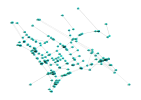

In [9]:
gplot(graph, locs_x, -locs_y, arrowlengthfrac=0.0, NODESIZE=0.02, nodelabel=1:num_nodes, NODELABELSIZE=2)

In [68]:
calc_cosine_dist(p1, p2) = dot(p1, p2) / (norm(p1) * norm(p2))

calc_euclidean_dist(p1, p2) = norm(p1 - p2)

function encode_edges(G, parent, node, src, dst)
    
    ret = fill(0.0, (max_out_degree, 14))
    
    x_u = norm_locs_x[node]
    y_u = norm_locs_y[node]
    x_dst = norm_locs_x[dst]
    y_dst = norm_locs_y[dst]

    for (idx, out_neighbor) in enumerate(outneighbors(G, node))
        
        out_neighbor == parent && continue
        
        x_v = norm_locs_x[out_neighbor]
        y_v = norm_locs_y[out_neighbor]
        
        ret[idx, 1] = edgeDict[Edge(node, out_neighbor)][:segmentlen]
        ret[idx, 2] = edgeDict[Edge(node, out_neighbor)][:speed]
        ret[idx, 3] = calc_euclidean_dist([x_v, y_v], [x_dst, y_dst])
        ret[idx, 4] = calc_cosine_dist([x_v-x_u, y_v-y_u], [x_dst-x_u, y_dst-y_u])
        ret[idx, 5] = x_v
        ret[idx, 6] = y_v
        ret[idx, 7] = edgeDict[Edge(node, out_neighbor)][:num_vehicles]
        ret[idx, 8] = edgeDict[Edge(node, out_neighbor)][:centrality]
        ret[idx, 9] = edgeDict[Edge(node, out_neighbor)][:rush_hour]
        ret[idx, 10] = edgeDict[Edge(node, out_neighbor)][:weather]
        ret[idx, 11] = float(edgeDict[Edge(node, out_neighbor)][:is_highway])
        ret[idx, 12] = edgeDict[Edge(node, out_neighbor)][:day_of_week]
        ret[idx, 13] = edgeDict[Edge(node, out_neighbor)][:is_holiday]
        ret[idx, end] = out_neighbor
        
    end
    
    return (ret, x_dst, y_dst)
    
end

encode_edges (generic function with 1 method)

In [69]:
function generate_stochastic_dataset(G; sample_size_lower_bound=100, verbose_frequent=10)
    
    pair_path_dict = Dict()
    sample_cnt = 0
    X = []
    y = []
    
    while true
        src = rand(1:num_nodes)
        dst = rand(1:num_nodes)
        
        src == dst && continue
        
        (src, dst) in keys(edge_weights) && continue    
        
        for (src, dst) in [(src, dst), (dst, src)]
    
            path = a_star(graph, src, dst, g_distmx)
            
            length(path) == 0 && continue
            
            pair_path_dict[(src, dst)] = path
            
            parent_node = 0
            cur_node = src
            
            for edge in path
                
#                 println("parent:($(parent_node)), X:($(cur_node), $(dst)), y:($(edge.dst))")
                
                
                push!(X, encode_edges(G, parent_node, cur_node, src, dst))
                push!(y, edge.dst)
                
                parent_node = cur_node
                cur_node = edge.dst
                
                sample_cnt += 1
                sample_cnt % verbose_frequent == 0 && println("Collected $(sample_cnt) samples.")
            end
        end
        
        sample_cnt >= sample_size_lower_bound && break
        
    end
    
    return X, y, pair_path_dict, sample_cnt
    
end

generate_stochastic_dataset (generic function with 1 method)

In [70]:
@time begin
features, labels, pair_path_dict, sample_cnt = generate_stochastic_dataset(graph, sample_size_lower_bound=10000, verbose_frequent=2000);
end
@assert length(features) == length(labels) == sample_cnt

Collected 2000 samples.
Collected 4000 samples.
Collected 6000 samples.
Collected 8000 samples.
Collected 10000 samples.
 21.662414 seconds (22.18 M allocations: 827.835 MiB, 2.12% gc time)


In [71]:
max_path_len = maximum(map(e -> length(e), values(pair_path_dict)))
println(max_path_len)

132


# Is data augmentation really helpful?
Perhap when overdone, data augmentation only makes it harder to train.
As of this moment, data augmentation will be ignored.

In [72]:
function find_label_idx(feature, label)
    
    num_row = size(feature)[1]
    ret_idx = 1
    
    for row_idx in 1:num_row
        if feature[row_idx, end] == label
            ret_idx = row_idx
        end
    end
    
    ret_idx
end

function augment_dataset(X, y; aug_multiple=20, verbose_frequent=500)
    
    org_sample_size = length(y)
    aug_sample_size = aug_multiple * org_sample_size
    feature_size = max_out_degree * 13 + 2
    
    X_aug, y_aug = zeros(Float32, aug_sample_size, feature_size), zeros(Int, aug_sample_size)
    indices = 1:max_out_degree
    
    cur_sample_idx = 1
    
    for pair in zip(X, y)
        feature = pair[1]
        label = pair[2]
        
        for _ in 1:aug_multiple
             
#             shuffled_indices = shuffle(MersenneTwister(now().instant.periods.value), indices)
            shuffled_indices = indices
            feature_tmp = feature[1][shuffled_indices, :]
            label_tmp = find_label_idx(feature_tmp, label)
            
            feature_tmp = transpose(feature_tmp[:, 1:end-1])

            
            X_aug[cur_sample_idx, :] = push!(vcat(feature_tmp...), feature[2], feature[3])
            y_aug[cur_sample_idx] = label_tmp - 1
            
            cur_sample_idx += 1
            
            if cur_sample_idx % verbose_frequent == 0
                println("Processed $(cur_sample_idx) samples")
            end
        end
    end
    
    return transpose(X_aug), y_aug
end

augment_dataset (generic function with 1 method)

In [73]:
X, y = augment_dataset(features, labels, aug_multiple=1, verbose_frequent=5000)

println(size(X))
println(size(y))

Processed 5000 samples
Processed 10000 samples
(54, 10059)
(10059,)


In [80]:
count(x -> x == 0, y)

7035

In [ ]:
split_at = [rand() > 0.2 for i in 1:length(y)]

X_train = X[:, split_at]
y_train = y[split_at]

X_val = X[:, .!split_at]
y_val = y[.!split_at];

In [ ]:
println(size(X_train))
println(size(y_train))
println(size(X_val))
println(size(y_val))

In [81]:
function build_model(context)

    mlp = @mx.chain mx.Variable(:data)             =>
      mx.FullyConnected(name=:fc1, num_hidden=1024) =>
      mx.Activation(name=:relu1, act_type=:relu)   =>
      mx.FullyConnected(name=:fc2, num_hidden=512)  =>
      mx.Activation(name=:relu2, act_type=:relu)   =>
      mx.FullyConnected(name=:fc3, num_hidden=max_out_degree)  =>
      mx.SoftmaxOutput(name=:softmax)
    
    return mx.FeedForward(mlp, context=context)
end

build_model (generic function with 1 method)

# First overfit the entire dataset

In [82]:
batch_size = 128

train_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size, shuffle=true)
val_provider = mx.ArrayDataProvider(X, y, batch_size=batch_size);

In [83]:
model = build_model(mx.gpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode softmax, MXNet.mx.Context[GPU0], #undef, #undef, #undef)

In [ ]:
mx.fit(model, mx.ADAM(),
    train_provider,
    n_epoch=10,
    eval_data=val_provider,
    verbosity=3)

In [95]:
using MLBase

pred = mx.predict(model, 
        mx.ArrayDataProvider(X, batch_size=batch_size), verbosity=0)

pred = map(i -> indmax(pred[:, i]), 1:length(y))

confusmat(max_out_degree, y+1, pred)

4×4 Array{Int64,2}:
 6961    69    5   0
   68  2509    0   0
    4    13  396   3
    0     1    0  30

In [97]:
function nn_infer_next_node(G, parent, cur_node, src, dst, model)

    input_vec, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    real_input_vec = push!(vcat(transpose(input_vec[:, 1:end-1])...), x_dst, y_dst)
    
    pred = mx.predict(model, mx.ArrayDataProvider(reshape(real_input_vec, :, 1)), verbosity=0)
    pred_idx = findmax(pred)[2]
    neighbor = Int(input_vec[pred_idx, end])
    
    if neighbor == 0
        
        avaliable_neighbors = filter(x -> x > 0, input_vec[:, end])
        
        if length(avaliable_neighbors) != 0
            println("Invalid prediction, randomizing next node")
            neighbor = Int(avaliable_neighbors[rand(1:end)])
        else
            # TODO the algorithm can be made smarter
            return -1, 0
        end
    end
    
    return neighbor, edge_weights[(cur_node, neighbor)]
end

function dijkstra_path_finder(G, src, dst, model; invalid_path_len_threshold=200)
    
    path = [src]
    parent_node = 0
    cur_node = src
    total_weights = 0.0
    
    while true
        if length(path) >= invalid_path_len_threshold
            return path, total_weights, false
        end
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, src, dst, model)
        
        if next_node == -1
            
            if !has_edge(G, (cur_node, parent_node))
                return path, total_weights, false
            end
            
            println("No available node to choose, turning back")
            parent_node, cur_node = cur_node, parent_node
            continue
        end
        
        total_weights += weight
        push!(path, next_node)
        
        if next_node == dst
            return path, total_weights, true
        end
        
        parent_node = cur_node
        cur_node = next_node
    end

end

function build_ground_truth_path(src, dst)
    
    edges = pair_path_dict[(src, dst)]
    
    path = [edges[1].src]
    
    for edge in edges
       push!(path, edge.dst) 
    end
    
    path
end

build_ground_truth_path (generic function with 1 method)

In [98]:
function calc_statistics(G, num_to_test)
   
    found_cnt = 0
    opt_path_cnt = 0
    
    pairs = shuffle(collect(keys(pair_path_dict)))[1:num_to_test]
    
    for pair in pairs
        src, dst = pair[1], pair[2]

        nn_path, _, found = dijkstra_path_finder(G, src, dst, model, 
                                invalid_path_len_threshold=max_path_len * 2)
        dijkstra_path = build_ground_truth_path(src, dst)
        
        found == false && continue
        
        found_cnt += 1
        
        if nn_path == dijkstra_path
            opt_path_cnt += 1
        else
            println(nn_path)
            println(dijkstra_path)
        end
    end
    
    return found_cnt, opt_path_cnt
end

calc_statistics (generic function with 1 method)

In [99]:
function print_paths_statistics(G, num_to_test)

    num_total_path = num_to_test

    found_cnt, opt_path_cnt = calc_statistics(G, num_to_test)
    
    @printf "%d out of %d can find path: %f\n" found_cnt num_total_path float(found_cnt)/num_total_path
    @printf "%d out of %d can find optimal path: %f\n" opt_path_cnt found_cnt float(opt_path_cnt)/found_cnt
    @printf "%d out of %d all paths can find optimal paths: %f\n" opt_path_cnt num_total_path float(opt_path_cnt)/num_total_path
    
end

print_paths_statistics (generic function with 1 method)

In [ ]:
print_paths_statistics(graph, 100)

# N.B.

When the model is able to find the optimal path
with high probability, the model has learned well.

In [ ]:
percentage_found = []
percentage_opt_found = []
percentage_opt_all = []

for _ in 1:10
    num_total_path = 200
    
    found_cnt, opt_path_cnt = calc_statistics(graph, num_total_path)
    push!(percentage_found, found_cnt/num_total_path)
    push!(percentage_opt_found, opt_path_cnt/found_cnt)
    push!(percentage_opt_all, opt_path_cnt/num_total_path)
end

In [ ]:
boxplot([percentage_found, percentage_opt_found, percentage_opt_all],
        labels=["found/all", "opt/found", "opt/all"]) # Basic

In [103]:
@pyimport networkx as nx

distmx = fill(Inf, (nv(graph), nv(graph)))

function build_networkx_graph(julia_graph)
    
    
    
    G = nx.DiGraph()
    
    for (edge, _) in edgeDict
#         print(node, coord[0], coord[1])
        weight = (0.5 * rand() + 0.5) * 
                        calc_euclidean_dist([norm_locs_x[edge.src], norm_locs_y[edge.src]], 
                                            [norm_locs_x[edge.dst], norm_locs_y[edge.dst]])
        nx.add_path(G, [edge.src, edge.dst], weight=weight)
        distmx[edge.src, edge.dst] = weight
    end
    
    G
end

function build_ground_truth_path(path_edges)
    
    path = [path_edges[1].src]
    edges = []
    
    for edge in path_edges
        push!(path, edge.dst)
        push!(edges, (edge.src, edge.dst))
    end
    
    return path, edges
end

function plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)
    
    G = build_networkx_graph(graph)
    
    pos = Dict()

    for node in 1:nv(graph)
        pos[node] = (locs_x[node], locs_y[node])
    end

    node_color = ["c" for _ in 1:nv(graph)];
    node_size = [0.01 for _ in 1:nv(graph)];
    
    # Mark ground truth path
    node_color[gt_path_nodes[end]] = "g"
    node_color[gt_path_nodes[1]] = "k"

    node_size[gt_path_nodes[1]] = 20
    node_size[gt_path_nodes[end]] = 20

    for node in gt_path_nodes[2:end-1]
        node_color[node] = "r"
        node_size[node] = 1
    end

    # Mark nn path
    for node in nn_path_nodes[2:end-1]
        node_color[node] = "b"
        node_size[node] = 1
    end
    
    nx.draw_networkx(G, pos=pos, 
                    with_labels=false,
                    nodelist=1:nv(graph),
                    node_size=node_size, 
                    width=0.01,
                    arrows=false,
                    node_color=node_color)
end

plot_gt_nn_comparison (generic function with 1 method)

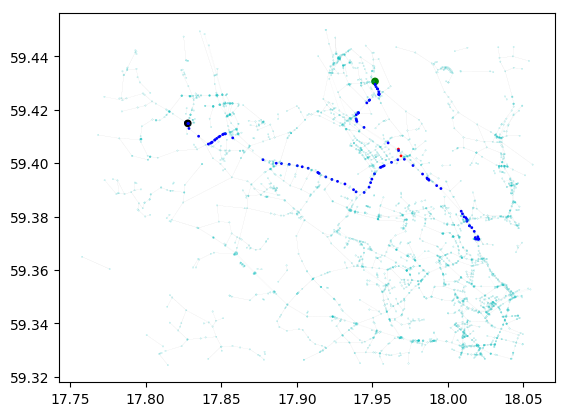

In [107]:
nn_path_nodes = [1082, 757, 3155, 3454, 176, 672, 1561, 766, 2887, 2834, 600, 2683, 854, 771, 104, 3116, 2945, 2533, 1997, 2676, 2279, 2451, 2146, 1238, 529, 897, 3266, 1439, 2639, 1719, 155, 169, 2699, 2096, 1292, 273, 2728, 2897, 759, 2635, 1154, 1970, 2006, 3378, 2851, 1391, 973, 590, 17, 862, 1488, 2103, 1397, 2391, 762, 300, 895, 833, 2833, 1395, 2841, 2382, 3022, 64, 375, 3408, 385, 9, 1592, 3199, 3194, 444, 1060, 2405, 2160, 1837, 2938, 1680, 2829, 1981, 532, 2708, 398, 1977, 1353, 3288, 1745, 579, 2172, 238, 2084, 1934, 373, 1957, 1546, 2487, 1533, 559, 3171, 1605, 213, 2641]
gt_path_nodes = [1082, 757, 3155, 3454, 176, 672, 1561, 766, 2887, 2834, 600, 2683, 854, 771, 104, 3116, 2945, 2533, 1997, 2676, 2279, 2451, 2146, 1238, 529, 897, 3266, 1439, 2639, 1719, 155, 169, 2699, 2096, 1292, 273, 2728, 2897, 759, 2635, 1154, 1970, 2006, 3378, 2851, 1391, 973, 395, 456, 2938, 1680, 2829, 1981, 532, 2708, 398, 1977, 1353, 3288, 1745, 579, 2172, 238, 2084, 1934, 373, 1957, 1546, 2487, 1533, 559, 3171, 1605, 213, 2641]
plot_gt_nn_comparison(graph, gt_path_nodes, nn_path_nodes)

### Building Simulation Environment

In [1]:
type Model
    name::String
    active::Bool
    src::Int
    dst::Int
    edge_src::Int
    edge_dst::Int
    start_t::Float64
    end_t::Float64
    elapsed_t::Float64
    left_t::Float64
end

In [81]:
function calc_temp_edge_weight(edge, traffic)
    
    segmentlen = edgeDict[Edge(edge[1], edge[2])][:segmentlen]
    speed = edgeDict[Edge(edge[1], edge[2])][:speed]
    
    weight = segmentlen / speed
    factor = 1 - e ^ (-0.08traffic)
    weight *= (1 + factor)
    
    return weight
end

function dummy_infer_next_node(G, parent, cur_node, Q)
    candidates = filter(node -> node != parent, outneighbors(G, cur_node))
    
    if length(candidates) == 0
        return (0.0, parent)
    end
    
    candidates = map(node -> (calc_temp_edge_weight((cur_node, node), Q[(cur_node, node)]),
                                node), candidates)
    return minimum(candidates)
end

function init_simulation(G, N)
    
    Q = Dict()
    M = Dict()
    
    for k in keys(edge_weights)
        Q[k] = 0
    end
    
    selected_edges = [sample(collect(keys(edge_weights))) for _ in 1:N]
    models = Array{Model, 1}(N)
    
    for edge in selected_edges
        Q[edge] += 1
    end
    
    edge_model_countor = Dict()
    
    for (idx, edge) in enumerate(selected_edges)
        
        edge_traffic = 0
        if haskey(edge_model_countor, edge)
            edge_traffic = edge_model_countor[edge]
            edge_model_countor[edge] += 1
        else
            edge_model_countor[edge] = 1
        end
        
        end_t = calc_temp_edge_weight(edge, edge_traffic)
        
        models[idx] = Model("model_$(idx)", true, 0, 0, edge[1], edge[2], 0.0, end_t, 0.0, end_t)
    end
    
    for model in models
        M[model.name] = []
    end
    
    return Q, M, models
end

import Base.isless

function isless(m1::Model, m2::Model)
    return m1.left_t <= m2.left_t
end

function pick_model_least_left_t(models)
   return minimum(filter(m -> m.active, models))
end

pick_model_least_left_t (generic function with 1 method)

In [82]:
function simulation(G; N=10, Z=Int(ceil(num_nodes * 0.2)))
    
    Q, M, models = init_simulation(graph, N)
    
    num_active_models = N
    
    while num_active_models > 0
        
        model_least = pick_model_least_left_t(models)
        
        if length(M[model_least.name]) >= Z
            num_active_models -= 1
            model_least.active = false
            Q[(model_least.edge_src, model_least.edge_dst)] -= 1
            
            # TODO
            # update all other models' time
            
            continue
        end
        
        next_weight, next_node = dummy_infer_next_node(G, 
                                        model_least.edge_src, 
                                        model_least.edge_dst,
                                        Q)
        
        if next_node == model_least.edge_src
            num_active_models -= 1
            model_least.active = false
            Q[(model_least.edge_src, model_least.edge_dst)] -= 1
            
            # TODO
            # update all other models' time
            
            continue
        end
        
        push!(M[model_least.name], 
            (model_least.edge_src, 
            model_least.edge_dst, 
            model_least.start_t, 
            model_least.end_t))
        
        Q[(model_least.edge_src, model_least.edge_dst)] -= 1
        model_least.edge_src = model_least.edge_dst
        model_least.edge_dst = next_node
        Q[(model_least.edge_src, model_least.edge_dst)] += 1
        model_least.elapsed_t = 0.0
        model_least.left_t = next_weight
        model_least.start_t = model_least.end_t
        model_least.end_t += next_weight
        
        # Parallelize this part
        for model in models
            
            (!model.active || model == model_least) && continue
            
            model.elapsed_t += model_least.left_t
            model.left_t -= model_least.left_t
        end
    end
    
    return M
end

simulation (generic function with 1 method)

In [83]:
M = simulation(graph)

LoadError: [91mArgumentError: reducing over an empty collection is not allowed[39m